# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random

from sklearn.preprocessing import Imputer

# Pretty display for notebooks
%matplotlib inline
%config InlineBachend.figure_format = 'retina'


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# Load data
azdias = pd.read_csv('Arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

azdias.head()

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Data shape
azdias.shape

(891221, 366)

In [5]:
# Data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
# Check object features
df_object = azdias.select_dtypes(include='object')

df_object.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1: Preprocessing

#### 1.1.1:  Assess Missing Data


 - use feature summary from the previous project
 - use DIAS Attributes - Values 2017.xlsx to complet the feature summary 

In [7]:
# Load in the feature summary file.
feat_info = pd.read_csv('Arvato_data/AZDIAS_Feature_Summary.csv', sep = ';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# feat_info shape
feat_info.shape

(85, 4)

In [9]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [10]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('Arvato_data/DIAS Attributes - Values 2017.xlsx', skiprows = [0])
del dias_attributes['Unnamed: 0']

# Drop NaN attribute
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isnull()]

# Drop attribute described in feat_info
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isin(feat_info.attribute)]

dias_attributes.head()

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months


In [11]:
# dias_attributes shape
dias_attributes.shape

(233, 4)

In [12]:
# dias_attributes Meanning counts
dias_attributes.Meaning.value_counts(dropna=False)

unknown                                             172
no transaction known                                 34
highest activity within the last 12 months           12
no transactions known                                10
no Online-transactions within the last 12 months      3
Universal                                             1
very low car quote                                    1
Name: Meaning, dtype: int64

In [13]:
# Investigate attribute with unknown Meaning
unknown_Meaning = dias_attributes[dias_attributes['Meaning']=='unknown']

# Keep only attribute of azdias
unknown_Meaning = unknown_Meaning[unknown_Meaning['Attribute'].isin(azdias.columns)]

# unknown_Meaning shape
unknown_Meaning.head()

,Attribute,Description,Value,Meaning
765,KBA05_ALTER1,share of car owners less than 31 years old,"-1, 9",unknown
771,KBA05_ALTER2,share of car owners inbetween 31 and 45 years ...,"-1, 9",unknown
777,KBA05_ALTER3,share of car owners inbetween 45 and 60 years ...,"-1, 9",unknown
783,KBA05_ALTER4,share of cars owners elder than 61 years,"-1, 9",unknown
790,KBA05_ANHANG,share of trailers in the microcell,"-1, 9",unknown


#### Guest attributes types

In [14]:
# Get first part of attribute
unknown_Meaning['first_att'] = unknown_Meaning.Attribute.apply(lambda x: x.split('_')[0])

In [15]:
unknown_Meaning.first_att.value_counts(dropna=False)

KBA13    106
KBA05     58
Name: first_att, dtype: int64

In [16]:
# Value of KBA05_ALTER1  
azdias.KBA05_ALTER1.value_counts(dropna=False)

 2.0    228625
 1.0    167046
 3.0    166129
NaN     133324
 0.0    102789
 4.0     78522
 9.0     14786
Name: KBA05_ALTER1, dtype: int64

In [17]:
# Values of KBA13_VORB_1  
azdias.KBA13_VORB_1.value_counts(dropna=False)

 3.0    361449
 2.0    167076
 4.0    158150
NaN     105800
 1.0     50939
 5.0     47807
Name: KBA13_VORB_1, dtype: int64

## Discusion

KBA13 and KBA05 are ordinal variabels

In [18]:
unknown_Meaning['type'] = 'ordinal'

In [19]:
# Investigate attribute with no transaction known
no_transaction = dias_attributes[dias_attributes['Meaning'].isin(['no transaction known',
                                                                  'no transactions known'])]

# Keep only attribute of azdias
no_transaction = no_transaction[no_transaction['Attribute'].isin(azdias.columns)]

# Get first part of attribute
no_transaction['first_att'] = no_transaction.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
no_transaction

,Attribute,Description,Value,Meaning,first_att
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known,D19
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known,D19
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known,D19
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known,D19
478,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known,D19
485,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,0,no transactions known,D19
546,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12...,0,no transactions known,D19
553,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24...,0,no transactions known,D19
617,D19_VERSI_ANZ_12,transaction activity INSURANCE in the last 12 ...,0,no transactions known,D19
624,D19_VERSI_ANZ_24,transaction activity INSURANCE in the last 24 ...,0,no transactions known,D19


In [20]:
# Values of D19_BANKEN_ANZ_12  
azdias.D19_BANKEN_ANZ_12.value_counts(dropna=False)

0    831734
1     29771
2     18067
3      5708
4      4082
5      1483
6       376
Name: D19_BANKEN_ANZ_12, dtype: int64

## Discusion

D19 are ordinal variabels

In [21]:
no_transaction['type'] = 'ordinal'

In [22]:
# Investigate the rest of attributes 
sub_dias = dias_attributes[~dias_attributes['Meaning'].isin(['no transaction known',
                                                             'no transactions known',
                                                            'unknown'])]

# Keep only attribute of azdias
sub_dias = sub_dias[sub_dias['Attribute'].isin(azdias.columns)]

# Get first part of attribute
sub_dias['first_att'] = sub_dias.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
sub_dias

,Attribute,Description,Value,Meaning,first_att
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
186,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
196,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
206,D19_BANKEN_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
319,D19_GESAMT_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
329,D19_GESAMT_OFFLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
339,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
349,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
384,D19_KONSUMTYP,consumption type,1,Universal,D19
492,D19_TELKO_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19


In [23]:
# Values of D19_KONSUMTYP
azdias.D19_KONSUMTYP.value_counts(dropna=False)

NaN     257113
 9.0    254296
 1.0    117912
 4.0     78262
 6.0     56562
 3.0     53330
 2.0     49324
 5.0     24422
Name: D19_KONSUMTYP, dtype: int64

### Discusion

All attribut in sub_dias are ordinal except D19_KONSUMTYP which is categorical

In [24]:
sub_dias['type'] = sub_dias.Meaning.apply(
    lambda x: 'categorical' if x=='Universal' else 'ordinal')

In [25]:
# Make a dataframe of features description
def_cl = lambda x: [str(k) for k in str(x).split(',')]
unknown_Meaning['missing_or_unknown'] = unknown_Meaning.Value.apply(def_cl)

# drop colums
unknown_Meaning.drop(['Description', 'Value', 'Meaning', 'first_att'],
                    axis=1, inplace=True)

# change columns name
unknown_Meaning.columns = ['attribute', 'type', 'missing_or_unknown']

unknown_Meaning.head()

,attribute,type,missing_or_unknown
765,KBA05_ALTER1,ordinal,"[-1, 9]"
771,KBA05_ALTER2,ordinal,"[-1, 9]"
777,KBA05_ALTER3,ordinal,"[-1, 9]"
783,KBA05_ALTER4,ordinal,"[-1, 9]"
790,KBA05_ANHANG,ordinal,"[-1, 9]"


In [26]:
# no_transaction
no_transaction['missing_or_unknown'] = no_transaction.Value.apply(lambda
                                                                 x: [str(x)])

# drop colums
no_transaction.drop(['Description', 'Value', 'Meaning', 'first_att'],
                    axis=1, inplace=True)

# change columns name
no_transaction.columns = ['attribute', 'type', 'missing_or_unknown']

no_transaction.head()

,attribute,type,missing_or_unknown
138,D19_BANKEN_ANZ_12,ordinal,[0]
145,D19_BANKEN_ANZ_24,ordinal,[0]
305,D19_GESAMT_ANZ_12,ordinal,[0]
312,D19_GESAMT_ANZ_24,ordinal,[0]
478,D19_TELKO_ANZ_12,ordinal,[0]


In [27]:

sub_dias['missing_or_unknown'] = sub_dias.Value.apply(lambda x: [])

# drop colums
sub_dias.drop(['Description', 'Value', 'Meaning', 'first_att'],
              axis=1, inplace=True)

# change columns name
sub_dias.columns = ['attribute', 'type', 'missing_or_unknown']

sub_dias.head()

,attribute,type,missing_or_unknown
152,D19_BANKEN_DATUM,ordinal,[]
186,D19_BANKEN_OFFLINE_DATUM,ordinal,[]
196,D19_BANKEN_ONLINE_DATUM,ordinal,[]
206,D19_BANKEN_ONLINE_QUOTE_12,ordinal,[]
319,D19_GESAMT_DATUM,ordinal,[]


In [28]:
# feat_info
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda 
                                                                        x: x[1:-1].split(','))

# drop information_level 
feat_info.drop(['information_level'], axis=1, inplace=True)

feat_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [29]:
# concat feat info
new_feat_info = pd.concat([feat_info, sub_dias, no_transaction,
                           unknown_Meaning], ignore_index=True)

In [30]:
# shape of new_feat_info
new_feat_info.shape

(276, 3)

In [31]:
# Columns without type
col = azdias.columns[~azdias.columns.isin(new_feat_info.attribute)]


In [32]:
# Check object features
sub_object = azdias[col].select_dtypes(include='object')
sub_object.head()

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00


In [33]:
sub_object.D19_LETZTER_KAUF_BRANCHE.value_counts(dropna=False)

NaN                       257113
D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN

In [34]:
describe = azdias[col].describe()
describe

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CJT_KATALOGNUTZER,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,8.912210e+05,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,817722.000000,798073.000000,886367.000000,...,793947.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,6.372630e+05,4.421928,11.745392,13.402658,14.476013,15.089627,13.700717,0.154018,7.599356,3.335264,...,2.539212,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,2.572735e+05,3.638805,4.097660,3.243300,2.712427,2.452932,5.079849,0.502389,14.332201,1.493633,...,0.754926,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.916530e+05,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,1.000000,8.000000,11.000000,13.000000,14.000000,11.000000,0.000000,1.000000,2.000000,...,2.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,6.372630e+05,3.000000,12.000000,14.000000,15.000000,15.000000,14.000000,0.000000,3.000000,4.000000,...,3.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,8.600680e+05,9.000000,15.000000,16.000000,17.000000,17.000000,17.000000,0.000000,9.000000,5.000000,...,3.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,1.082873e+06,9.000000,18.000000,18.000000,18.000000,18.000000,25.000000,11.000000,449.000000,5.000000,...,3.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [35]:
# Data information
dias_info = pd.read_excel('Arvato_data/DIAS Information Levels - Attributes 2017.xlsx', skiprows = [0])
del dias_info['Unnamed: 0']
dias_info = dias_info[dias_info.Attribute.isin(col)]

dias_info

,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN


In [36]:
# List of columns to drop

col_to_drop = list(sub_object.columns)

## Discusion

 - Drop the two object variable
 - auther variable as numeric variables


In [37]:
last_att_info = pd.DataFrame({'attribute': list(describe.columns)})
last_att_info['type'] = 'numeric'
last_att_info['missing_or_unknown'] = last_att_info['type'].apply(lambda
                                                                 x:[])

last_att_info.head()

,attribute,type,missing_or_unknown
0,LNR,numeric,[]
1,AKT_DAT_KL,numeric,[]
2,ALTER_KIND1,numeric,[]
3,ALTER_KIND2,numeric,[]
4,ALTER_KIND3,numeric,[]


In [38]:
# concat last_att_info and new_feat_info
new_feat_info = pd.concat([new_feat_info, last_att_info], ignore_index=True)

new_feat_info.shape

(364, 3)

#### Convert Missing Value Codes to NaNs

In [39]:
# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(new_feat_info['attribute'], 
                                  new_feat_info['missing_or_unknown']):
    if len(missing_values) != 0:
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [40]:
# Drop col_to_drop
azdias.drop(col_to_drop, axis=1, inplace=True)

# check shape
azdias.shape

(891221, 364)

In [41]:
# Missing Data in Each Column
count_nan = azdias.isnull().sum()/len(azdias)

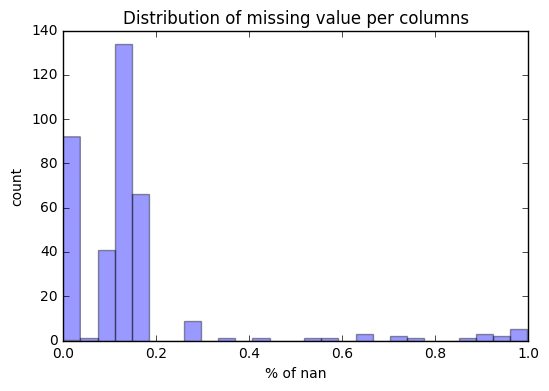

In [42]:
plt.figure()
sns.distplot(count_nan.values, kde=False)
plt.ylabel('count')
plt.xlabel('% of nan')
plt.title('Distribution of missing value per columns')
plt.show()

#### Discusion

Drop columns that have more than 30% of missing values

In [43]:
# Get columns that have more than 30% of nan
more_30 = count_nan[count_nan > 0.3]
missing_col = list(more_30.index)
len(missing_col)

21

In [44]:
# Remove the outlier missing_col from the dataset. 
azdias.drop(missing_col, axis=1, inplace=True)

azdias.shape

(891221, 343)

####  Assess Missing Data in Each Row

In [ ]:
# Missing Data in Each Column
row_nan = azdias.isnull().sum(axis=1)/azdias.shape[1]

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')